In [28]:
from dataset import DogsCatsTest
from utils import load_model
from model import get_model

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import torchvision
from torchvision.transforms import v2
torchvision.disable_beta_transforms_warning()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json


In [29]:
RUN_NAME = "2023-11-29_17-16-14"

run_path = f"runs/{RUN_NAME}/"

train_summary = json.load(open(run_path + "train_summary.json"))

MODEL = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]
BATCH_SIZE = train_summary["config"]["BATCH_SIZE"]
PRETRAINED = train_summary["config"]["PRETRAINED"]

print(f"MODEL: {MODEL}")
print(f"Pretrained: {PRETRAINED}")

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_model(MODEL)
model = load_model(model, run_path + "best_model.pt")
model.to(DEVICE)


MODEL: EfficientNetV2S
Pretrained: True


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [30]:

test_transform = v2.Compose([
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
        v2.ToImage(),
        # v2.ToDtype(torch.float),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    ])

test_dataset = DogsCatsTest(root_dir='dataset/DogsCats/test/', 
                                          transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [31]:
print("Test data size: ", len(test_dataloader.dataset))

Test data size:  12500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


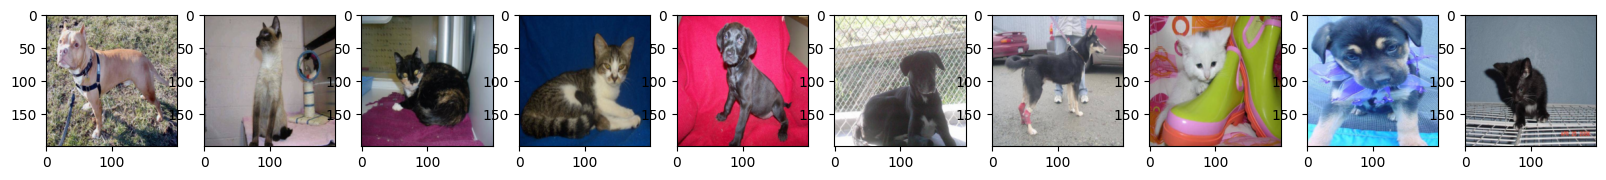

In [32]:
#plot 10 random images from test dataset
fig = plt.figure(figsize=(20,20))
for i in range(10):
    idx = torch.randint(len(test_dataset),(1,)).item()
    img = test_dataset[idx][0]
    img = img.permute(1,2,0)
    fig.add_subplot(1,10,i+1)
    plt.imshow(img.squeeze(),cmap='gray')
plt.show()


In [6]:
model.eval()

ids = []
predictions = []
with torch.no_grad():
    for data, name in test_dataloader:
        data = data.to(DEVICE)

        output = model(data)
        preds = torch.sigmoid(output)
        preds = preds.tolist()
        predictions = predictions+preds
        ids = ids+list(name)


In [7]:
len(predictions)

12500

In [9]:
#change ids to int
ids = [int(x) for x in ids]

In [10]:
submission = pd.DataFrame({'id':ids,'label':predictions})

submission = submission.sort_values(by=['id'])


In [12]:
submission.to_csv('submission.csv', index=False)